In [1]:
import numpy as np
from collections import Counter

def syllable_to_phrase_labels(arr, silence=-1):
    new_arr = np.array(arr, dtype=int)
    current_syllable = None
    start_of_phrase_index = None
    first_non_silence_label = None  # To track the first non-silence syllable

    for i, value in enumerate(new_arr):
        if value != silence and value != current_syllable:
            if start_of_phrase_index is not None:
                new_arr[start_of_phrase_index:i] = current_syllable
            current_syllable = value
            start_of_phrase_index = i
            
            if first_non_silence_label is None:  # Found the first non-silence label
                               first_non_silence_label = value

    if start_of_phrase_index is not None:
        new_arr[start_of_phrase_index:] = current_syllable

    # Replace the initial silence with the first non-silence syllable label
    if new_arr[0] == silence and first_non_silence_label is not None:
        for i in range(len(new_arr)):
            if new_arr[i] != silence:
                break
            new_arr[i] = first_non_silence_label

    return new_arr

def reduce_phrases(arr, remove_silence=True):
    current_element = arr[0]
    reduced_list = [] 

    for i, value in enumerate(arr):
        if value != current_element:
            reduced_list.append(current_element)
            current_element = value 

        # append last phrase
        if i == len(arr) - 1:
            reduced_list.append(current_element)

    if remove_silence == True:
        reduced_list = [value for value in reduced_list if value != 0]

    return np.array(reduced_list)

def majority_vote(data, window_size=1):
    """
    Apply majority vote on the input data with a specified window size.

    Parameters:
    - data: list or array-like
      The input data to apply majority vote on.
    - window_size: int, default=3
      The size of the window to apply majority vote. Must be an odd number.

    Returns:
    - output: ndarray
      The array with majority vote applied.
    """
    # Function to find the majority element in a window
    def find_majority(window):
        count = Counter(window)
        majority = max(count.values())
        for num, freq in count.items():
            if freq == majority:
                return num
        return window[len(window) // 2]  # Return the middle element if no majority found

    # Ensure the input data is in list form
    if isinstance(data, str):
        data = [int(x) for x in data.split(',') if x.strip().isdigit()]

    # Initialize the output array with a padding at the beginning
    output = [data[0]] * (window_size // 2)  # Pad with the first element

    # Apply the majority vote on each window
    for i in range(len(data) - window_size + 1):
        window = data[i:i + window_size]
        output.append(find_majority(window))

    # Pad the output array at the end to match the input array size
    output.extend([data[-1]] * (window_size // 2))

    return np.array(output)

def smooth_labels(labels, window_size=50):
    labels = np.array(labels)
    for i in range(len(labels)):
        if labels[i] == -1:
            left = right = i
            while left >= 0 or right < len(labels):
                if left >= 0 and labels[left] != -1:
                    labels[i] = labels[left]
                    break
                if right < len(labels) and labels[right] != -1:
                    labels[i] = labels[right]
                    break
                left -= 1
                right += 1
    smoothed_labels = np.zeros_like(labels)
    for i in range(len(labels)):
        start = max(0, i - window_size // 2)
        end = min(len(labels), i + window_size // 2 + 1)
        window = labels[start:end]
        unique, counts = np.unique(window, return_counts=True)
        smoothed_labels[i] = unique[np.argmax(counts)]
    return smoothed_labels

import numpy as np

def calculate_state_durations(labels):
    labels = np.array(labels)
    unique_labels = np.unique(labels)  # Find all unique labels
    state_durations = {}

    for label in unique_labels:  # Loop over each unique label
        durations = []
        current_duration = 0

        for i in range(len(labels)):
            if labels[i] == label:  # If the label matches the current unique label
                current_duration += 1
            else:
                if current_duration > 0:  # If the streak ends, store the duration
                    durations.append(current_duration)
                    current_duration = 0

        # Append the final duration for the label if the last few elements were the same
        if current_duration > 0:
            durations.append(current_duration)

        # Store the durations for this label
        state_durations[label] = durations

    return state_durations




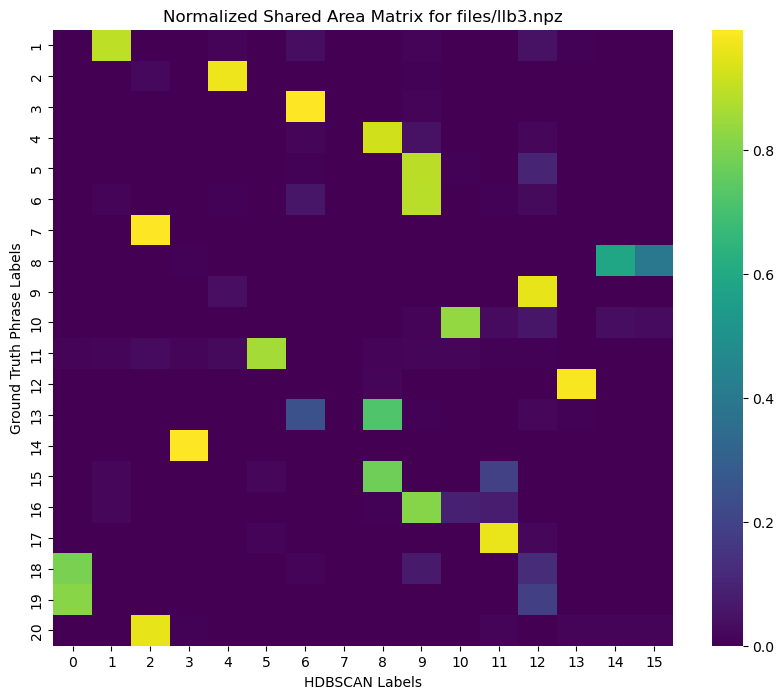

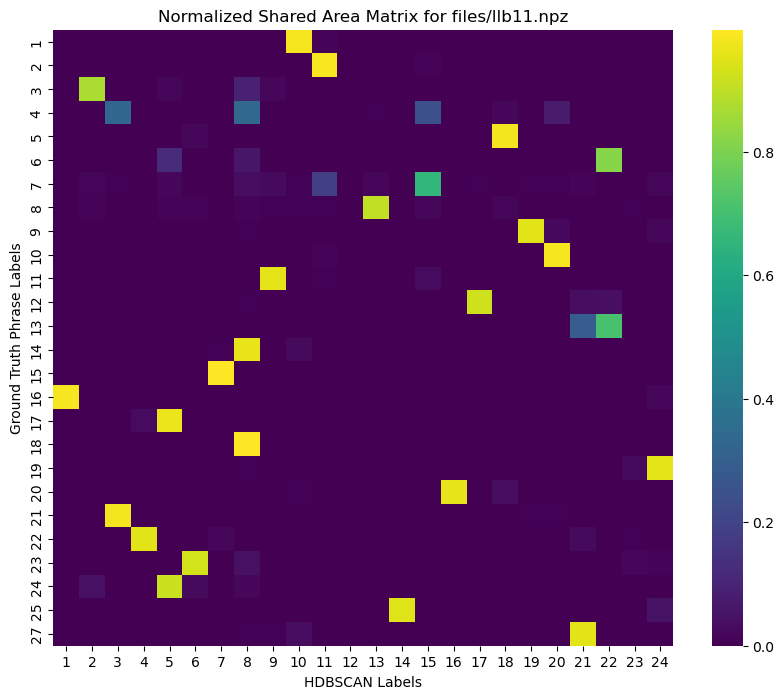

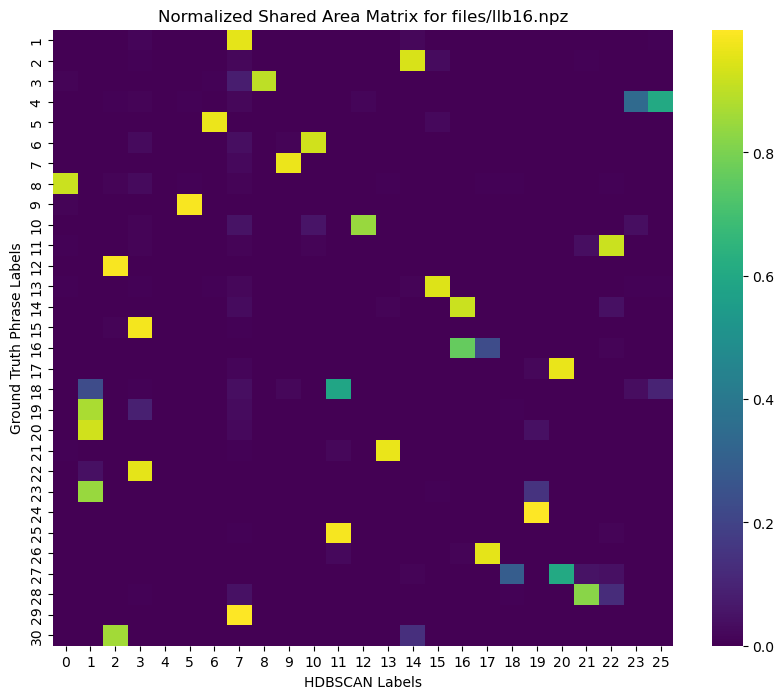

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import linear_sum_assignment

files = ["files/llb3.npz", "files/llb11.npz", "files/llb16.npz"]
smoothing_window_length = [0, 25]

for file in files:
    data = np.load(file)
    
    # phrase duration of ground truth vs UMAP embedding
    ground_truth_labels = data['ground_truth_labels']
    hdbscan_labels = data['hdbscan_labels']

    # convert to phrase labels
    ground_truth_phrase_labels = syllable_to_phrase_labels(ground_truth_labels, silence=0)

    # shared area matrix

    # for unique label in ground truth, calculate the number of unique labels in hdbscan
    unique_ground_truth_labels = np.unique(ground_truth_phrase_labels)
    unique_hdbscan_labels = np.unique(hdbscan_labels)
    shared_area_matrix = np.zeros((len(unique_ground_truth_labels), len(unique_hdbscan_labels)))

    for i, ground_truth_label in enumerate(unique_ground_truth_labels):
        for j, hdbscan_label in enumerate(unique_hdbscan_labels):
            shared_area_matrix[i, j] = np.sum((ground_truth_phrase_labels == ground_truth_label) & (hdbscan_labels == hdbscan_label))

    # Normalize each row to sum to 1
    row_sums = shared_area_matrix.sum(axis=1, keepdims=True)
    normalized_matrix = shared_area_matrix / row_sums  # Divide each row by its sum

    # Use the Hungarian algorithm to find an optimal diagonal arrangement
    cost_matrix = -normalized_matrix  # We negate the matrix to maximize the sum
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    # Rearrange rows and columns based on the optimal assignment
    optimal_matrix = normalized_matrix[row_ind][:, col_ind]
    optimal_ground_truth_labels = unique_ground_truth_labels[row_ind]
    optimal_hdbscan_labels = unique_hdbscan_labels[col_ind]

    # Plot the optimally rearranged shared area matrix without numbers in the cells
    plt.figure(figsize=(10, 8))
    sns.heatmap(optimal_matrix, annot=False, cmap="viridis", xticklabels=optimal_hdbscan_labels, yticklabels=optimal_ground_truth_labels)
    plt.xlabel('HDBSCAN Labels')
    plt.ylabel('Ground Truth Phrase Labels')
    plt.title(f'Optimally Arranged Normalized Shared Area Matrix for {file}')
    plt.show()


In [ ]:
    plt.figure(figsize=(12, 8))
    
    for window_size in smoothing_window_length:
        smoothed_ground_truth_labels = smooth_labels(ground_truth_phrase_labels, window_size=window_size)
        state_durations = calculate_state_durations(smoothed_ground_truth_labels)
        unique_states, counts = np.unique(smoothed_ground_truth_labels, return_counts=True)

        # Calculate average durations for each unique state
        avg_durations = []
        current_idx = 0

        # Iterate through each unique state and calculate durations
        for state in unique_states:
            state_durations_for_state = []
            current_duration = 0

            # Traverse through smoothed labels to get durations of the current state
            for i in range(len(smoothed_ground_truth_labels)):
                if smoothed_ground_truth_labels[i] == state:
                    current_duration += 1
                elif current_duration > 0:
                    state_durations_for_state.append(current_duration)
                    current_duration = 0

            # Capture any final duration for the last state
            if current_duration > 0:
                state_durations_for_state.append(current_duration)

            # Calculate the average duration for this state
            avg_durations.append(np.mean(state_durations_for_state))

        # Sort durations and states by descending order of durations
        sorted_idx = np.argsort(avg_durations)[::-1]
        sorted_avg_durations = np.array(avg_durations)[sorted_idx]
        sorted_unique_states = np.array(unique_states)[sorted_idx]

        # Plot using seaborn for better aesthetics
        sns.barplot(x=sorted_unique_states, y=sorted_avg_durations, alpha=0.7, label=f'Smoothing Window {window_size}')
    
    # Plot for ground truth labels
    ground_truth_durations = calculate_state_durations(ground_truth_phrase_labels)
    unique_states, counts = np.unique(ground_truth_phrase_labels, return_counts=True)
    avg_durations = []

    for state in unique_states:
        state_durations_for_state = []
        current_duration = 0

        # Traverse through ground truth labels to get durations of the current state
        for i in range(len(ground_truth_phrase_labels)):
            if ground_truth_phrase_labels[i] == state:
                current_duration += 1
            elif current_duration > 0:
                state_durations_for_state.append(current_duration)
                current_duration = 0

        # Capture any final duration for the last state
        if current_duration > 0:
            state_durations_for_state.append(current_duration)

        # Calculate the average duration for this state
        avg_durations.append(np.mean(state_durations_for_state))

    # Sort ground truth durations and states by descending order of durations
    sorted_idx = np.argsort(avg_durations)[::-1]
    sorted_avg_durations = np.array(avg_durations)[sorted_idx]
    sorted_unique_states = np.array(unique_states)[sorted_idx]

    # Plot ground truth using seaborn
    sns.barplot(x=sorted_unique_states, y=sorted_avg_durations, alpha=0.7, label='Ground Truth', color='black')

    plt.xlabel('Unique States')
    plt.ylabel('Average Phrase Duration')
    plt.title(f'Phrase Duration for {file}')
    plt.legend()
    plt.show()